## Efficient and Accurate Modeling of Flow through Dipping Aquifers with MODFLOW 6

In [1]:
%run ./routines_rev1.ipynb
%run ./figures_rev1.ipynb
ws = './disu_model'

domain = True              # option to include "domain" (True) or not (False)
spdis_recalc = True        # option to recalculate specific discharge within the notebook
dztol = 0.00001            # tolerance for determining overlap (dz > dztol) in a vertically staggered grid

<>:21: DeprecationWarning: invalid escape sequence \c
C:\Users\19904604\AppData\Local\Temp\ipykernel_14932\3528270814.py:21: DeprecationWarning: invalid escape sequence \c
  ax.annotate("Flux magnitude = %0.2f m/d\nFlux direction = %0.2f$^\circ$\nFlow error = %0.1f %s"


In [2]:
# scenario parameters
# scenario names -- keys of parameters dictionary are scenario names
#                   built automatically from scenario options
# staggered -- vertically staggered grid, i.e., cross-connections (True)
#              or not, i.e., vertically offset (False)
# xt3d -- xt3d on (True) or off, i.e., standard formulation (False)

# scenario options
options = [
    {
        "optionname": "staggered",
        "optionstrings": {
            False: "-vo",
            True: "-vs",
        },
    },
    {
        "optionname": "xt3d",
        "optionstrings": {
            False: "-s",
            True: "-x",
        },
    },
]

# build parameters dictionary
parameters = build_parameters(options)

Lz =  14.773502691896258
zspan =  8.773502691896258
Max head error =  0.7604496615670886


C:\Users\19904604\Anaconda3\envs\loop3denv\lib\site-packages\flopy\plot\crosssection.py:1020: UserWarning: Warning: converting a masked element to nan.
  u = np.array([u_tmp.ravel()[cell] for cell in sorted(projpts)])
C:\Users\19904604\Anaconda3\envs\loop3denv\lib\site-packages\flopy\plot\crosssection.py:1021: UserWarning: Warning: converting a masked element to nan.
  v = np.array([vz.ravel()[cell] for cell in sorted(projpts)])


Max head error =  0.7572525373259449
Max head error =  0.13892117776097201
Max head error =  4.428220038921182e-05


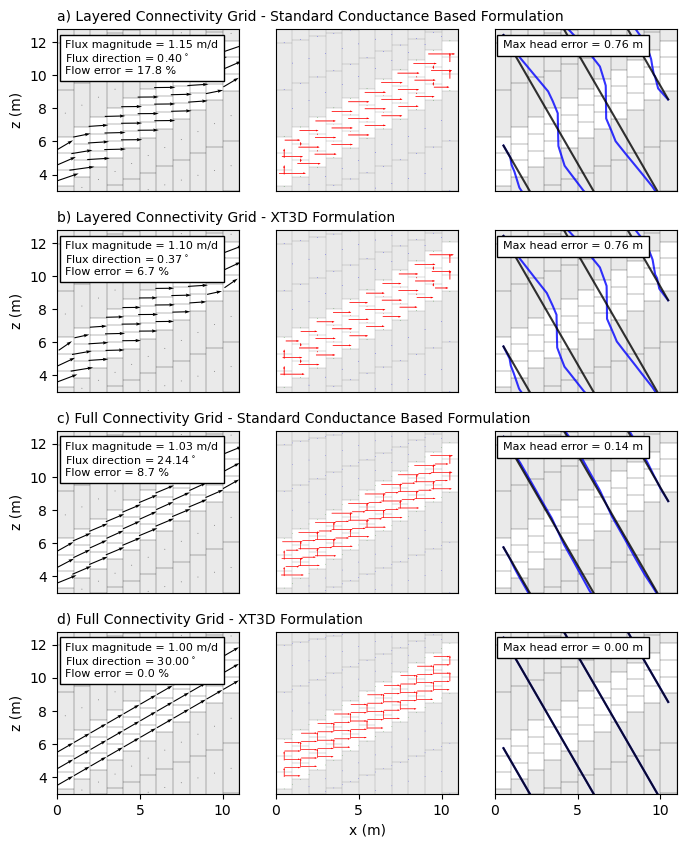

In [3]:
# Lx is the full width of the model. The grid spacing in the x direction is
# delr = Lx / ncol, and so the horizontal distance between the left and right
# boundary conditions is Lx - delr. The cells in the channel are square, i.e.,
# delz_chan = delr. The cross-sectional model has unit thickness "into the page,"
# i.e., nrow = 1 and delc = 1.

# The full thickness of the channel measured vertically is nlay_chan * delz_chan.
# Theta is the angle (deg) at which the channel slopes, and so the width of the
# "true" channel measured perpendicularly to the slope, i.e., the width available 
# for flow along the slope of the channel, is nlay_chan * delz_chan * cos(theta).
# The increase in elevation (vertical offset) as one moves a column to the right
# within the channel is delr * tan(theta).

# adjustable grid parameters
nlay_chan = 3                         # number of layers in channel
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model
theta = 30.                           # angle of inclination of channel
k_dom = 1e-6                          # domain conductivity
anisotropic = False

# set up dis grid and conductivities
mgs, nlay_dom_upper, icelltype, delz_chan, zspan, zthick, zthick_dom_ll, thick_arr \
    = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain)
cond = set_up_cond(k_dom)

# Calculate volumetric flow Analytical = kai 
flow_analytical = 1 * zthick * math.cos(math.radians(theta)) * 1

# arrays for storing results
models_all, head_all, spdismf6_all, q_all, qx_all, qy_all, qz_all, qnface_all, flow_all = [], [], [], [], [], [], [], [], []

# loop over scenarios
fig = plt.figure(figsize = (8,10))#, constrained_layout=True)
nscen = len(parameters)
for i in range(nscen):
    # convert to disu grid
    d2d = convert_to_disu(mgs, i, dztol)
    xface, yface, zface, ifacetype = get_face_info(d2d)
    # run scenario and store results
    gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid, qnface, flow, flow_error = simulation(i)
    models_all.append(gwf), head_all.append(head), spdismf6_all.append(spdismf6)
    qx_all.append(qx), qy_all.append(qy), qz_all.append(qz)
    q_all.append((qmagmid, qangmid, flow_error))
    qnface_all.append(qnface)
    flow_all.append(flow)
    extent = (0., Lx, zthick_dom_ll, zthick_dom_ll + zspan + delz_chan)
    #extent = None
    #dxdysin = float(Lx / ncol) * 1. * math.sin(theta * math.pi / 180.)
    scale_bndy = 10. ### * 0.5 * (1. + k_dom)
    head_diff = head - head_analyt
    print("Max head error = ", head_diff.max())
    fig2(i, vmin = -20, vmax = 0, extent=extent,
    scale_chan=10., scale_bndy=scale_bndy, scale_dom=10., normalize=False)
    plt.tight_layout
fig.savefig('../figures/fig2_paper.png' , dpi = 450)

In [4]:
table1()

Layered Connectivity (SCB)
qmagmid =  1.1547291121601075
qangmid =  0.40342968280697644
vol_flow =  3.0598067701866904  Analytical = 2.598076211353316 

Layered Connectivity (XT3D)
qmagmid =  1.0992719270852187
qangmid =  0.36926548196347636
vol_flow =  2.7711639645096473  Analytical = 2.598076211353316 

Full Connectivity (SCB)
qmagmid =  1.0284324418628352
qangmid =  24.1359406605633
vol_flow =  2.822995736994332  Analytical = 2.598076211353316 

Full Connectivity (XT3D)
qmagmid =  0.999998436568256
qangmid =  29.999951839669006
vol_flow =  2.598080316259025  Analytical = 2.598076211353316 



### Investigating adding model layers within hydrogeologic layers 

In [5]:
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model
theta = 30.                           # angle of inclination of channel
k_dom = 1.e-6                         # domain conductivity

# grid resolution cases
resolution_scenarios = np.arange(1,10,1)
nr = len(resolution_scenarios)

res_results = [] 

# loop over grid resolution cases
for n in range(nr):
    nlay_chan = resolution_scenarios[n]   # number of layers in channel
    # set up dis grid and conductivities
    mgs, nlay_dom_upper, icelltype, delz_chan, zspan, zthick, zthick_dom_ll, thick_arr \
        = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain)
    cond = set_up_cond(k_dom)
    
    # Calculate volumetric flow Analytical = kai 
    flow_analytical = 1 * zthick * math.cos(math.radians(theta)) * 1    
    print(zthick)
    results = []
    for i in range(nscen):
        # convert to disu grid
        d2d = convert_to_disu(mgs, i, dztol)
        xface, yface, zface, ifacetype = get_face_info(d2d)
        # run scenario and store results
        gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid, qnface, flow, flow_error = simulation(i)  
        results.append((qmagmid, qangmid, flow_error))
    res_results.append(results)  
fig3_results = np.array(res_results)

Lz =  8.773502691896258
zspan =  6.773502691896257
1.0
Lz =  11.773502691896258
zspan =  7.773502691896257
2.0
Lz =  14.773502691896258
zspan =  8.773502691896258
3.0
Lz =  17.773502691896258
zspan =  9.773502691896258
4.0
Lz =  20.773502691896258
zspan =  10.773502691896258
5.0
Lz =  23.773502691896258
zspan =  11.773502691896258
6.0
Lz =  26.773502691896258
zspan =  12.773502691896258
7.0
Lz =  29.773502691896258
zspan =  13.773502691896258
8.0
Lz =  32.773502691896255
zspan =  14.773502691896258
9.0


<>:21: DeprecationWarning: invalid escape sequence \c
C:\Users\19904604\AppData\Local\Temp\ipykernel_14932\3528270814.py:21: DeprecationWarning: invalid escape sequence \c
  ax.annotate("Flux magnitude = %0.2f m/d\nFlux direction = %0.2f$^\circ$\nFlow error = %0.1f %s"
C:\Users\19904604\AppData\Local\Temp\ipykernel_14932\398292387.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


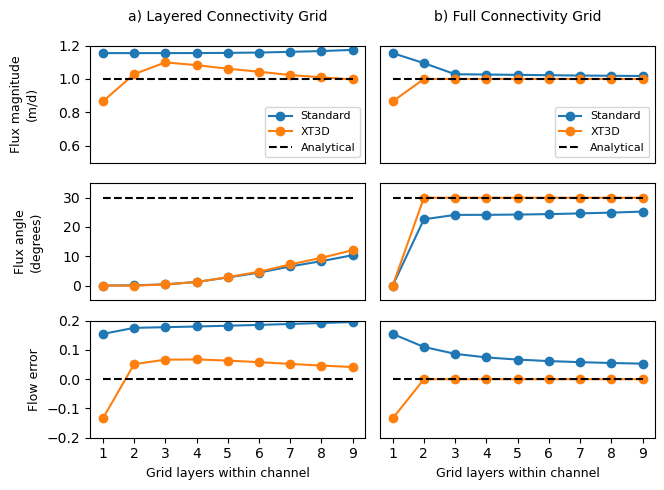

In [14]:
%run ./figures_rev1.ipynb
fig3()

### Investigating K contrast between hydrogeologic layer and domain

In [7]:
nlay_chan = 3                         # number of layers in channel
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model

# dip and K contrast cases
dip = np.arange(0, 75, 2.5)   # For nice contours use (0,80,1)
#log = np.arange(0, 3, 0.5)    # For nice contours use (0,4,0.2)
log = [0, np.log10(2), np.log10(5), 1, 2]
#log = [0.25, 0.5, 1, 2]
Kcontrast = [10**i for i in log]
Kcontrast = np.round(Kcontrast, 0)
# arrays for storing results
qmag_results = np.zeros((4, len(Kcontrast), len(dip)))
qang_results = np.zeros((4, len(Kcontrast), len(dip)))
dip_array = np.zeros((4, len(Kcontrast), len(dip)))
Kcontrast_array = np.zeros((4, len(Kcontrast), len(dip)))

# loop over scenarios
for s in range(len(parameters)):
    # loop over dip cases
    for d in range(len(dip)):
        theta = dip[d]                        # angle of inclination of channel
        # set up dis grid
        mgs, nlay_dom_upper, icelltype, delz_chan, zspan, zthick, zthick_dom_ll, thick_arr \
            = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain)
        d2d = convert_to_disu(mgs, s, dztol)
        xface, yface, zface, ifacetype = get_face_info(d2d)
        # loop over K contrast cases
        for kc in range(len(Kcontrast)):
            print('sim = %i, dip = %f0.1, contrast = %f0.2' %(s, dip[d], Kcontrast[kc]))
            k_dom = 1./Kcontrast[kc]              # domain conductivity
            # set up conductivities
            cond = set_up_cond(k_dom)
            # run case and store results
            #print('\nk_contrast = %i, dip = %i, scenario = %i' %(Kcontrast[kc], dip[d], s))
            gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid, qnface, flow, flow_error = simulation(s)
            qmag_results[s][kc][d] = qmagmid
            qang_results[s][kc][d] = qangmid  
            Kcontrast_array[s][kc][d] = Kcontrast[kc]
            dip_array[s][kc][d] = dip[d]

Lz =  9.0
zspan =  3.0
sim = 0, dip = 0.0000000.1, contrast = 1.0000000.2
sim = 0, dip = 0.0000000.1, contrast = 2.0000000.2
sim = 0, dip = 0.0000000.1, contrast = 5.0000000.2
sim = 0, dip = 0.0000000.1, contrast = 10.0000000.2
sim = 0, dip = 0.0000000.1, contrast = 100.0000000.2
Lz =  9.43660942908512
zspan =  3.4366094290851206
sim = 0, dip = 2.5000000.1, contrast = 1.0000000.2
sim = 0, dip = 2.5000000.1, contrast = 2.0000000.2
sim = 0, dip = 2.5000000.1, contrast = 5.0000000.2
sim = 0, dip = 2.5000000.1, contrast = 10.0000000.2
sim = 0, dip = 2.5000000.1, contrast = 100.0000000.2
Lz =  9.87488663525924
zspan =  3.87488663525924
sim = 0, dip = 5.0000000.1, contrast = 1.0000000.2
sim = 0, dip = 5.0000000.1, contrast = 2.0000000.2
sim = 0, dip = 5.0000000.1, contrast = 5.0000000.2
sim = 0, dip = 5.0000000.1, contrast = 10.0000000.2
sim = 0, dip = 5.0000000.1, contrast = 100.0000000.2
Lz =  10.316524975873959
zspan =  4.316524975873959
sim = 0, dip = 7.5000000.1, contrast = 1.0000000.2


sim = 0, dip = 22.5000000.1, contrast = 5.0000000.2
sim = 0, dip = 22.5000000.1, contrast = 10.0000000.2
sim = 0, dip = 22.5000000.1, contrast = 100.0000000.2
Lz =  13.663076581549987
zspan =  7.663076581549986
sim = 0, dip = 25.0000000.1, contrast = 1.0000000.2
sim = 0, dip = 25.0000000.1, contrast = 2.0000000.2
sim = 0, dip = 25.0000000.1, contrast = 5.0000000.2
sim = 0, dip = 25.0000000.1, contrast = 10.0000000.2
sim = 0, dip = 25.0000000.1, contrast = 100.0000000.2
Lz =  14.205670505517462
zspan =  8.205670505517462
sim = 0, dip = 27.5000000.1, contrast = 1.0000000.2
sim = 0, dip = 27.5000000.1, contrast = 2.0000000.2
sim = 0, dip = 27.5000000.1, contrast = 5.0000000.2
sim = 0, dip = 27.5000000.1, contrast = 10.0000000.2
sim = 0, dip = 27.5000000.1, contrast = 100.0000000.2
Lz =  14.773502691896258
zspan =  8.773502691896258
sim = 0, dip = 30.0000000.1, contrast = 1.0000000.2
sim = 0, dip = 30.0000000.1, contrast = 2.0000000.2
sim = 0, dip = 30.0000000.1, contrast = 5.0000000.2
sim

sim = 0, dip = 45.0000000.1, contrast = 100.0000000.2
Lz =  19.913085010692715
zspan =  13.913085010692715
sim = 0, dip = 47.5000000.1, contrast = 1.0000000.2
sim = 0, dip = 47.5000000.1, contrast = 2.0000000.2
sim = 0, dip = 47.5000000.1, contrast = 5.0000000.2
sim = 0, dip = 47.5000000.1, contrast = 10.0000000.2
sim = 0, dip = 47.5000000.1, contrast = 100.0000000.2
Lz =  20.9175359259421
zspan =  14.9175359259421
sim = 0, dip = 50.0000000.1, contrast = 1.0000000.2
sim = 0, dip = 50.0000000.1, contrast = 2.0000000.2
sim = 0, dip = 50.0000000.1, contrast = 5.0000000.2
sim = 0, dip = 50.0000000.1, contrast = 10.0000000.2
sim = 0, dip = 50.0000000.1, contrast = 100.0000000.2
Lz =  22.03225372841206
zspan =  16.03225372841206
sim = 0, dip = 52.5000000.1, contrast = 1.0000000.2
sim = 0, dip = 52.5000000.1, contrast = 2.0000000.2
sim = 0, dip = 52.5000000.1, contrast = 5.0000000.2
sim = 0, dip = 52.5000000.1, contrast = 10.0000000.2
sim = 0, dip = 52.5000000.1, contrast = 100.0000000.2
Lz =

sim = 0, dip = 70.0000000.1, contrast = 2.0000000.2
sim = 0, dip = 70.0000000.1, contrast = 5.0000000.2
sim = 0, dip = 70.0000000.1, contrast = 10.0000000.2
sim = 0, dip = 70.0000000.1, contrast = 100.0000000.2
Lz =  40.71594802363211
zspan =  34.71594802363211
sim = 0, dip = 72.5000000.1, contrast = 1.0000000.2
sim = 0, dip = 72.5000000.1, contrast = 2.0000000.2
sim = 0, dip = 72.5000000.1, contrast = 5.0000000.2
sim = 0, dip = 72.5000000.1, contrast = 10.0000000.2
sim = 0, dip = 72.5000000.1, contrast = 100.0000000.2
Lz =  9.0
zspan =  3.0
sim = 1, dip = 0.0000000.1, contrast = 1.0000000.2
sim = 1, dip = 0.0000000.1, contrast = 2.0000000.2
sim = 1, dip = 0.0000000.1, contrast = 5.0000000.2
sim = 1, dip = 0.0000000.1, contrast = 10.0000000.2
sim = 1, dip = 0.0000000.1, contrast = 100.0000000.2
Lz =  9.43660942908512
zspan =  3.4366094290851206
sim = 1, dip = 2.5000000.1, contrast = 1.0000000.2
sim = 1, dip = 2.5000000.1, contrast = 2.0000000.2
sim = 1, dip = 2.5000000.1, contrast = 5.

sim = 1, dip = 17.5000000.1, contrast = 100.0000000.2
Lz =  12.639702342662023
zspan =  6.639702342662023
sim = 1, dip = 20.0000000.1, contrast = 1.0000000.2
sim = 1, dip = 20.0000000.1, contrast = 2.0000000.2
sim = 1, dip = 20.0000000.1, contrast = 5.0000000.2
sim = 1, dip = 20.0000000.1, contrast = 10.0000000.2
sim = 1, dip = 20.0000000.1, contrast = 100.0000000.2
Lz =  13.142135623730951
zspan =  7.14213562373095
sim = 1, dip = 22.5000000.1, contrast = 1.0000000.2
sim = 1, dip = 22.5000000.1, contrast = 2.0000000.2
sim = 1, dip = 22.5000000.1, contrast = 5.0000000.2
sim = 1, dip = 22.5000000.1, contrast = 10.0000000.2
sim = 1, dip = 22.5000000.1, contrast = 100.0000000.2
Lz =  13.663076581549987
zspan =  7.663076581549986
sim = 1, dip = 25.0000000.1, contrast = 1.0000000.2
sim = 1, dip = 25.0000000.1, contrast = 2.0000000.2
sim = 1, dip = 25.0000000.1, contrast = 5.0000000.2
sim = 1, dip = 25.0000000.1, contrast = 10.0000000.2
sim = 1, dip = 25.0000000.1, contrast = 100.0000000.2
Lz

sim = 1, dip = 42.5000000.1, contrast = 2.0000000.2
sim = 1, dip = 42.5000000.1, contrast = 5.0000000.2
sim = 1, dip = 42.5000000.1, contrast = 10.0000000.2
sim = 1, dip = 42.5000000.1, contrast = 100.0000000.2
Lz =  19.0
zspan =  12.999999999999998
sim = 1, dip = 45.0000000.1, contrast = 1.0000000.2
sim = 1, dip = 45.0000000.1, contrast = 2.0000000.2
sim = 1, dip = 45.0000000.1, contrast = 5.0000000.2
sim = 1, dip = 45.0000000.1, contrast = 10.0000000.2
sim = 1, dip = 45.0000000.1, contrast = 100.0000000.2
Lz =  19.913085010692715
zspan =  13.913085010692715
sim = 1, dip = 47.5000000.1, contrast = 1.0000000.2
sim = 1, dip = 47.5000000.1, contrast = 2.0000000.2
sim = 1, dip = 47.5000000.1, contrast = 5.0000000.2
sim = 1, dip = 47.5000000.1, contrast = 10.0000000.2
sim = 1, dip = 47.5000000.1, contrast = 100.0000000.2
Lz =  20.9175359259421
zspan =  14.9175359259421
sim = 1, dip = 50.0000000.1, contrast = 1.0000000.2
sim = 1, dip = 50.0000000.1, contrast = 2.0000000.2
sim = 1, dip = 50.

sim = 1, dip = 65.0000000.1, contrast = 100.0000000.2
Lz =  33.14213562373095
zspan =  27.14213562373095
sim = 1, dip = 67.5000000.1, contrast = 1.0000000.2
sim = 1, dip = 67.5000000.1, contrast = 2.0000000.2
sim = 1, dip = 67.5000000.1, contrast = 5.0000000.2
sim = 1, dip = 67.5000000.1, contrast = 10.0000000.2
sim = 1, dip = 67.5000000.1, contrast = 100.0000000.2
Lz =  36.474774194546214
zspan =  30.474774194546217
sim = 1, dip = 70.0000000.1, contrast = 1.0000000.2
sim = 1, dip = 70.0000000.1, contrast = 2.0000000.2
sim = 1, dip = 70.0000000.1, contrast = 5.0000000.2
sim = 1, dip = 70.0000000.1, contrast = 10.0000000.2
sim = 1, dip = 70.0000000.1, contrast = 100.0000000.2
Lz =  40.71594802363211
zspan =  34.71594802363211
sim = 1, dip = 72.5000000.1, contrast = 1.0000000.2
sim = 1, dip = 72.5000000.1, contrast = 2.0000000.2
sim = 1, dip = 72.5000000.1, contrast = 5.0000000.2
sim = 1, dip = 72.5000000.1, contrast = 10.0000000.2
sim = 1, dip = 72.5000000.1, contrast = 100.0000000.2
Lz

sim = 2, dip = 15.0000000.1, contrast = 5.0000000.2
sim = 2, dip = 15.0000000.1, contrast = 10.0000000.2
sim = 2, dip = 15.0000000.1, contrast = 100.0000000.2
Lz =  12.152987888789834
zspan =  6.152987888789835
sim = 2, dip = 17.5000000.1, contrast = 1.0000000.2
sim = 2, dip = 17.5000000.1, contrast = 2.0000000.2
sim = 2, dip = 17.5000000.1, contrast = 5.0000000.2
sim = 2, dip = 17.5000000.1, contrast = 10.0000000.2
sim = 2, dip = 17.5000000.1, contrast = 100.0000000.2
Lz =  12.639702342662023
zspan =  6.639702342662023
sim = 2, dip = 20.0000000.1, contrast = 1.0000000.2
sim = 2, dip = 20.0000000.1, contrast = 2.0000000.2
sim = 2, dip = 20.0000000.1, contrast = 5.0000000.2
sim = 2, dip = 20.0000000.1, contrast = 10.0000000.2
sim = 2, dip = 20.0000000.1, contrast = 100.0000000.2
Lz =  13.142135623730951
zspan =  7.14213562373095
sim = 2, dip = 22.5000000.1, contrast = 1.0000000.2
sim = 2, dip = 22.5000000.1, contrast = 2.0000000.2
sim = 2, dip = 22.5000000.1, contrast = 5.0000000.2
sim 

sim = 2, dip = 37.5000000.1, contrast = 100.0000000.2
Lz =  17.3909963117728
zspan =  11.390996311772799
sim = 2, dip = 40.0000000.1, contrast = 1.0000000.2
sim = 2, dip = 40.0000000.1, contrast = 2.0000000.2
sim = 2, dip = 40.0000000.1, contrast = 5.0000000.2
sim = 2, dip = 40.0000000.1, contrast = 10.0000000.2
sim = 2, dip = 40.0000000.1, contrast = 100.0000000.2
Lz =  18.163311740174233
zspan =  12.163311740174233
sim = 2, dip = 42.5000000.1, contrast = 1.0000000.2
sim = 2, dip = 42.5000000.1, contrast = 2.0000000.2
sim = 2, dip = 42.5000000.1, contrast = 5.0000000.2
sim = 2, dip = 42.5000000.1, contrast = 10.0000000.2
sim = 2, dip = 42.5000000.1, contrast = 100.0000000.2
Lz =  19.0
zspan =  12.999999999999998
sim = 2, dip = 45.0000000.1, contrast = 1.0000000.2
sim = 2, dip = 45.0000000.1, contrast = 2.0000000.2
sim = 2, dip = 45.0000000.1, contrast = 5.0000000.2
sim = 2, dip = 45.0000000.1, contrast = 10.0000000.2
sim = 2, dip = 45.0000000.1, contrast = 100.0000000.2
Lz =  19.91308

sim = 2, dip = 62.5000000.1, contrast = 2.0000000.2
sim = 2, dip = 62.5000000.1, contrast = 5.0000000.2
sim = 2, dip = 62.5000000.1, contrast = 10.0000000.2
sim = 2, dip = 62.5000000.1, contrast = 100.0000000.2
Lz =  30.445069205095585
zspan =  24.445069205095585
sim = 2, dip = 65.0000000.1, contrast = 1.0000000.2
sim = 2, dip = 65.0000000.1, contrast = 2.0000000.2
sim = 2, dip = 65.0000000.1, contrast = 5.0000000.2
sim = 2, dip = 65.0000000.1, contrast = 10.0000000.2
sim = 2, dip = 65.0000000.1, contrast = 100.0000000.2
Lz =  33.14213562373095
zspan =  27.14213562373095
sim = 2, dip = 67.5000000.1, contrast = 1.0000000.2
sim = 2, dip = 67.5000000.1, contrast = 2.0000000.2
sim = 2, dip = 67.5000000.1, contrast = 5.0000000.2
sim = 2, dip = 67.5000000.1, contrast = 10.0000000.2
sim = 2, dip = 67.5000000.1, contrast = 100.0000000.2
Lz =  36.474774194546214
zspan =  30.474774194546217
sim = 2, dip = 70.0000000.1, contrast = 1.0000000.2
sim = 2, dip = 70.0000000.1, contrast = 2.0000000.2
si

sim = 3, dip = 10.0000000.1, contrast = 100.0000000.2
Lz =  11.216946626429399
zspan =  5.216946626429399
sim = 3, dip = 12.5000000.1, contrast = 1.0000000.2
sim = 3, dip = 12.5000000.1, contrast = 2.0000000.2
sim = 3, dip = 12.5000000.1, contrast = 5.0000000.2
sim = 3, dip = 12.5000000.1, contrast = 10.0000000.2
sim = 3, dip = 12.5000000.1, contrast = 100.0000000.2
Lz =  11.679491924311227
zspan =  5.679491924311227
sim = 3, dip = 15.0000000.1, contrast = 1.0000000.2
sim = 3, dip = 15.0000000.1, contrast = 2.0000000.2
sim = 3, dip = 15.0000000.1, contrast = 5.0000000.2
sim = 3, dip = 15.0000000.1, contrast = 10.0000000.2
sim = 3, dip = 15.0000000.1, contrast = 100.0000000.2
Lz =  12.152987888789834
zspan =  6.152987888789835
sim = 3, dip = 17.5000000.1, contrast = 1.0000000.2
sim = 3, dip = 17.5000000.1, contrast = 2.0000000.2
sim = 3, dip = 17.5000000.1, contrast = 5.0000000.2
sim = 3, dip = 17.5000000.1, contrast = 10.0000000.2
sim = 3, dip = 17.5000000.1, contrast = 100.0000000.2
L

sim = 3, dip = 35.0000000.1, contrast = 2.0000000.2
sim = 3, dip = 35.0000000.1, contrast = 5.0000000.2
sim = 3, dip = 35.0000000.1, contrast = 10.0000000.2
sim = 3, dip = 35.0000000.1, contrast = 100.0000000.2
Lz =  16.673269879789604
zspan =  10.673269879789604
sim = 3, dip = 37.5000000.1, contrast = 1.0000000.2
sim = 3, dip = 37.5000000.1, contrast = 2.0000000.2
sim = 3, dip = 37.5000000.1, contrast = 5.0000000.2
sim = 3, dip = 37.5000000.1, contrast = 10.0000000.2
sim = 3, dip = 37.5000000.1, contrast = 100.0000000.2
Lz =  17.3909963117728
zspan =  11.390996311772799
sim = 3, dip = 40.0000000.1, contrast = 1.0000000.2
sim = 3, dip = 40.0000000.1, contrast = 2.0000000.2
sim = 3, dip = 40.0000000.1, contrast = 5.0000000.2
sim = 3, dip = 40.0000000.1, contrast = 10.0000000.2
sim = 3, dip = 40.0000000.1, contrast = 100.0000000.2
Lz =  18.163311740174233
zspan =  12.163311740174233
sim = 3, dip = 42.5000000.1, contrast = 1.0000000.2
sim = 3, dip = 42.5000000.1, contrast = 2.0000000.2
si

Lz =  26.320508075688767
zspan =  20.320508075688767
sim = 3, dip = 60.0000000.1, contrast = 1.0000000.2
sim = 3, dip = 60.0000000.1, contrast = 2.0000000.2
sim = 3, dip = 60.0000000.1, contrast = 5.0000000.2
sim = 3, dip = 60.0000000.1, contrast = 10.0000000.2
sim = 3, dip = 60.0000000.1, contrast = 100.0000000.2
Lz =  28.20982126971165
zspan =  22.20982126971165
sim = 3, dip = 62.5000000.1, contrast = 1.0000000.2
sim = 3, dip = 62.5000000.1, contrast = 2.0000000.2
sim = 3, dip = 62.5000000.1, contrast = 5.0000000.2
sim = 3, dip = 62.5000000.1, contrast = 10.0000000.2
sim = 3, dip = 62.5000000.1, contrast = 100.0000000.2
Lz =  30.445069205095585
zspan =  24.445069205095585
sim = 3, dip = 65.0000000.1, contrast = 1.0000000.2
sim = 3, dip = 65.0000000.1, contrast = 2.0000000.2
sim = 3, dip = 65.0000000.1, contrast = 5.0000000.2
sim = 3, dip = 65.0000000.1, contrast = 10.0000000.2
sim = 3, dip = 65.0000000.1, contrast = 100.0000000.2
Lz =  33.14213562373095
zspan =  27.14213562373095
sim

In [8]:
len(Kcontrast)

5

<>:21: DeprecationWarning: invalid escape sequence \c
C:\Users\19904604\AppData\Local\Temp\ipykernel_14932\3528270814.py:21: DeprecationWarning: invalid escape sequence \c
  ax.annotate("Flux magnitude = %0.2f m/d\nFlux direction = %0.2f$^\circ$\nFlow error = %0.1f %s"


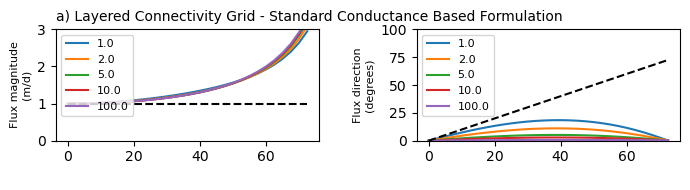

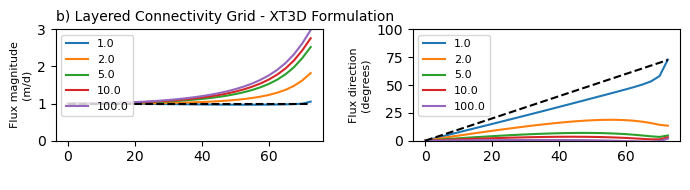

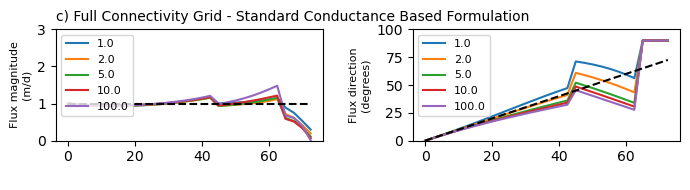

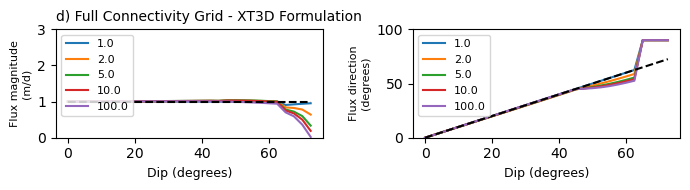

In [9]:
%run ./figures_rev1.ipynb
fig4()

In [10]:
# ANISOTROPY TEST
nlay_chan = 3
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model
theta = 30.                           # angle of inclination of channel
k_dom = 1.e-6                         # domain conductivity
dip = 30
anisotropic = True

anisotropic_scenarios = [1,10,100,1000,10000]
nr = len(anisotropic_scenarios)

ani_results = [] 

# loop over grid resolution cases
for n in range(nr):
    ratio = anisotropic_scenarios[n]
    print(ratio)
    
    # set up dis grid and conductivities
    mgs, nlay_dom_upper, icelltype, delz_chan, zspan, zthick, zthick_dom_ll, thick_arr \
        = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain)
    cond = set_up_cond(k_dom)
    
    # Calculate volumetric flow Analytical = kai 
    flow_analytical = 1 * zthick * math.cos(math.radians(theta)) * 1    
    
    results = []
    for i in range(nscen):
        # convert to disu grid
        d2d = convert_to_disu(mgs, i, dztol)
        xface, yface, zface, ifacetype = get_face_info(d2d)
        # run scenario and store results
        gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid, qnface, flow, flow_error = simulation(i)  
        results.append((qmagmid, qangmid, flow_error))
    ani_results.append(results)  
fig5_results = np.array(ani_results)

1
Lz =  14.773502691896258
zspan =  8.773502691896258
10
Lz =  14.773502691896258
zspan =  8.773502691896258
100
Lz =  14.773502691896258
zspan =  8.773502691896258
1000
Lz =  14.773502691896258
zspan =  8.773502691896258
10000
Lz =  14.773502691896258
zspan =  8.773502691896258


<>:21: DeprecationWarning: invalid escape sequence \c
C:\Users\19904604\AppData\Local\Temp\ipykernel_14932\3528270814.py:21: DeprecationWarning: invalid escape sequence \c
  ax.annotate("Flux magnitude = %0.2f m/d\nFlux direction = %0.2f$^\circ$\nFlow error = %0.1f %s"
C:\Users\19904604\AppData\Local\Temp\ipykernel_14932\608700512.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


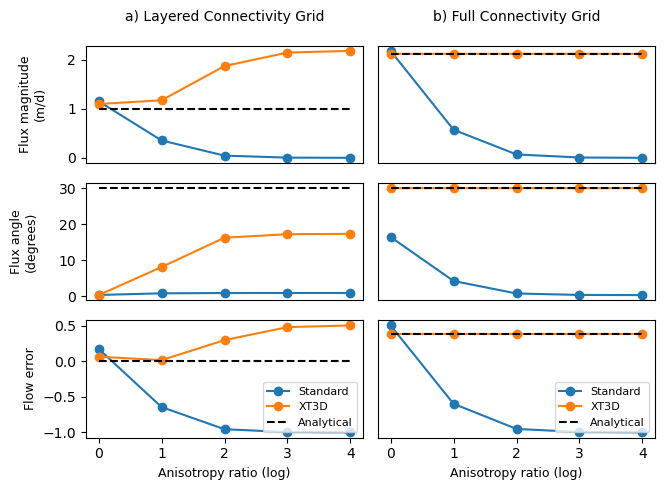

In [15]:
%run ./figures_rev1.ipynb
fig5()